# 数据集定义与加载

深度学习模型在训练时需要大量的数据来完成模型调优，这个过程均是数字的计算，无法直接使用原始图片和文本等来完成计算。因此与需要对原始的各种数据文件进行处理，转换成深度学习模型可以使用的数据类型。

飞桨内的数据集加载过程由 [paddle.io.Dataset](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/io/Dataset_cn.html#dataset) 和 [paddle.io.DataLoader](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/io/DataLoader_cn.html#dataloader) 两个api完成。Dataset主要完成单张图像或样本的解析与标签的制作，DataLoader主要完成单张图像或样本的组batch工作和对数据集的多进程读取加速作用。

飞桨内置了深度学习任务中常用的数据集，对应API所在目录为 [paddle.vision.datasets](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/Overview_cn.html#api) 与 [paddle.text](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/text/Overview_cn.html#paddle-text) ，你可以通过以下代码查看飞桨框架中的内置数据集。

In [1]:
import paddle
print('视觉相关数据集：', paddle.vision.datasets.__all__)
print('自然语言相关数据集：', paddle.text.__all__)

视觉相关数据集： ['DatasetFolder', 'ImageFolder', 'MNIST', 'FashionMNIST', 'Flowers', 'Cifar10', 'Cifar100', 'VOC2012']
自然语言相关数据集： ['Conll05st', 'Imdb', 'Imikolov', 'Movielens', 'UCIHousing', 'WMT14', 'WMT16', 'ViterbiDecoder', 'viterbi_decode']


## 加载数据集

通过飞桨框架，可以很方便的加载深度学习里的常用数据集。下面演示如何快速加载MNIST数据集。

在加载过程中，会通过`transform`字段传入一些对图像进行变换的操作，飞桨在 [paddle.vision.transforms](https://www.paddlepaddle.org.cn/documentation/docs/zh/api/paddle/vision/Overview_cn.html#about-transforms)里提供了一些常用的图像变换操作，如对图像进行中心裁剪、水平翻转图像和对图像进行归一化等，这里在初始化MNIST数据集时传入了 `ToTensor` 变换来将图像转换为飞桨的内置数据类型, `mode`字段用于区分训练集和测试集。

In [3]:
from paddle.vision.transforms import ToTensor

# 下载数据集并初始化DataSet
train_dataset = paddle.vision.datasets.MNIST(mode='train', transform=ToTensor())
test_dataset = paddle.vision.datasets.MNIST(mode='test', transform=ToTensor())
print('train images: ',len(train_dataset),', test images: ',len(test_dataset))

train images:  60000 , test images:  10000


## 迭代数据集&可视化

完成数据集初始化之后，可以使用下面的代码直接对数据集进行迭代

shape of image:  [1, 28, 28]


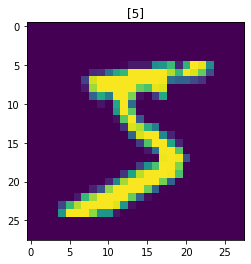

In [9]:
from matplotlib import pyplot as plt

for data in train_dataset:
    image, label = data
    print('shape of image: ',image.shape)
    plt.title(str(label))
    plt.imshow(image[0])    
    break

## 自定义数据集


在实际的场景中，需要使用已有的数据来定义数据集。这时可以使用飞桨提供的`paddle.io.Dataset`基类来快速实现自定义数据集。

自定义数据集需要集成自 `paddle.io.Dataset` 并且实现下面的三个方法

1. `__init__`: 完成一些数据集初始化操作，定义数据集大小
2. `__getitem__`: 定义给定index时如何获取数据，在此函数中需要完成数据的预处理工作，如读取图像，对图像进行数据增强和制作标签等操作，最终返回处理好的单条数据（训练数据，对应的标签）
3. `__len__`: 返回数据集总数目

In [41]:
import numpy as np
from paddle.io import Dataset

class MyDataset(Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, num_samples, image_size=(28,28), class_num=10):
        """
        步骤二：实现构造函数，定义数据集大小
        """
        super(MyDataset, self).__init__()
        self.num_samples = num_samples
        self.image_size = image_size
        self.class_num = class_num

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        image = np.random.rand(*self.image_size)
        image = np.expand_dims(image, axis=0)
        label = np.random.randint(0, self.class_num - 1)

        return image, label

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return self.num_samples

和内置数据集一样，可以直接对自定义数据集进行迭代

shape of image:  (1, 28, 28)


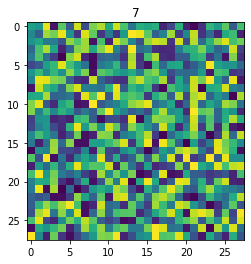

In [42]:
custom_dataset = MyDataset(BATCH_SIZE * BATCH_NUM)

for data in custom_dataset:
    image, label = data
    print('shape of image: ',image.shape)
    plt.title(str(label))
    plt.imshow(image[0])    
    break

## 使用DataLoader 读取训练数据集

通过直接迭代DataSet的方式虽然可以对数据集进行访问，但是这种访问方式只能单线程进行并且还需要手动进行Batch的组合。在飞桨中，推荐使用 `paddle.io.DataLoader`来对数据集进行多进程的读取并且自动完成组batch的工作，开发者只需要进行数据处理部分逻辑的编写。

[飞桨高层API](https://www.paddlepaddle.org.cn/documentation/docs/zh/practices/quick_start/high_level_api.html#api) 自动完成DataLoader的过程, 对于非高层API的使用情况，可以通过如下代码，可以快速的使用`paddle.io.DataLoader`完成数据的加载。

shape of image:  [64, 1, 28, 28] shape of label:  [64, 1]


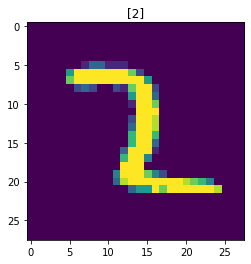

In [47]:
train_loader = paddle.io.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1)
for batch_id, data in enumerate(train_loader()):
    images, labels = data
    print('shape of image: ',images.shape, 'shape of label: ', labels.shape)
    plt.title(str(labels[0].numpy()))
    plt.imshow(images[0][0])    
    break

通过上述的方法，可以初始化一个数据迭代器train_loader, 用于加载训练数据。通过batch_size=64设置了数据集的批大小为64，通过设置shuffle=True可以在取数据前会打乱数据集顺序。此外，还可以通过设置num_workers来开启多进程数据加载，提升加载速度。